In [169]:
import torch
torch.manual_seed(42)
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [197]:
def draw_circle(x, y, radius, col='g'):
    # helper function to draw a circle with a given color
    th = torch.arange(0,2*np.pi,0.01)
    xunit = radius * torch.cos(th) + x
    yunit = radius * torch.sin(th) + y
    plt.plot(xunit, yunit, col)
    return xunit, yunit

In [171]:
N = 100 # number of samples/trajectories
H = 30 # horizon for each trajectory
a_dim = 2 # dimension for action space, v and w

## Sample controls from a given mean and variance

In [199]:
v_mean = torch.tensor([12]) # mean for velocity
v_var = torch.tensor([2]) # variance for velocity
w_mean = torch.tensor([0]) # mean for angular velocity
w_var = torch.tensor([2]) # variance for angular velocity

In [200]:
u = torch.randn(N,H,a_dim) # sample the controls from a normal distribution with 0 mean and 1 variance
print(u.shape)
print(torch.mean(u[:,:,0]))
print(torch.mean(u[:,:,1]))
############ 
print(torch.std(u[:,:,0]))
print(torch.std(u[:,:,1]))

torch.Size([100, 30, 2])
tensor(0.0236)
tensor(0.0137)
tensor(1.0094)
tensor(1.0006)


In [201]:
# update the distribution to the user-defined mean and variance
u[:,:,0] = u[:,:,0]*v_var+v_mean
u[:,:,1] = u[:,:,1]*w_var+w_mean
print(torch.mean(u[:,:,0]))
print(torch.mean(u[:,:,1]))
print(torch.std(u[:,:,0]))
print(torch.std(u[:,:,1]))
print("Max v: ", torch.max(u[:,:,0]))
print("Min v: ", torch.min(u[:,:,0]))
print("Max w: ", torch.max(u[:,:,1]))
print("Min w: ", torch.min(u[:,:,1]))

tensor(12.0472)
tensor(0.0273)
tensor(2.0188)
tensor(2.0013)
Max v:  tensor(18.9874)
Min v:  tensor(5.0004)
Max w:  tensor(7.4415)
Min w:  tensor(-8.4357)


## Clip samples within it's bounds

In [202]:
def clip(u, v_bound, w_bound):
    '''
    function to clip the velocity and angular velocity within it's bounds
    v_bound = [v_min, v_max]
    w_bound = [w_min, w_max]
    '''
    for i in range(u.shape[0]):
        for j in range(u.shape[1]):
            if(u[i,j,0]<v_bound[0]):
                u[i,j,0]=v_bound[0]
            if(u[i,j,0]>v_bound[1]):
                u[i,j,0]=v_bound[1]
            if(u[i,j,1]<w_bound[0]):
                u[i,j,1]=w_bound[0]
            if(u[i,j,1]>w_bound[1]):
                u[i,j,1]=w_bound[1]
    return u

In [203]:
u = clip(u, [8,20], [-0.5,0.5])

print("Max v: ", torch.max(u[:,:,0]))
print("Min v: ", torch.min(u[:,:,0]))
print("Max w: ", torch.max(u[:,:,1]))
print("Max w: ", torch.min(u[:,:,1]))

Max v:  tensor(18.9874)
Min v:  tensor(8.)
Max w:  tensor(0.5000)
Max w:  tensor(-0.5000)


## Rollout the trajectories using unicycle model

In [204]:
def unicycle(state,u,dt=0.1):
    '''
    state = current state of the vehicle [x,y,theta]
    u = [v,w]
    '''
    state[2] = state[2]+u[1]*dt
    state[0] = state[0] + u[0]*torch.cos(state[2])*dt
    state[1] = state[1] + u[0]*torch.sin(state[2])*dt
    return state

In [205]:
start_state = torch.tensor([0,0,torch.deg2rad(torch.tensor([90]))]) # the starting state of the vehicle

In [206]:
def rollout(u, start_state):
    '''
    function to rollout the N trajectories using the unicycle model.
    u = sampled controls
    start_state = starting state of the vehicle
    '''
    traj_N = torch.zeros([N,H+1,3]) # each trajectory is of size H+1 where position 0 is the current state of the vehicle
    traj_N[:,0,:]=start_state
    for i in range(N):
        for j in range(1,H):
            new_state = unicycle(traj_N[i,j-1,:],u[i,j,:],dt=0.1)
            traj_N[i,j,:] = new_state
    return traj_N

traj_N = rollout(u,start_state)

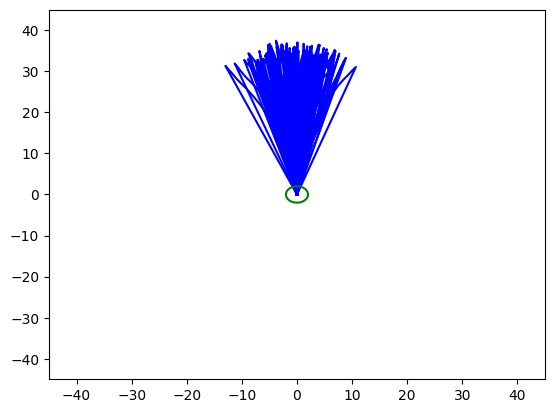

In [207]:
# plot the sampled trajectories
for i in range(N):
    plt.plot(traj_N[i,:,0],traj_N[i,:,1],color='blue')
draw_circle(0, 0, radius=2)
plt.xlim([-45,45])
plt.ylim([-45,45])
plt.show()

## Score trajectories

### Smoothness cost

In [208]:
smoothness_cost_v_N = torch.zeros(N)
smoothness_cost_w_N = torch.zeros(N)
for i in range(N):
    for j in range(1,H):
        v1 = u[i,j-1,0]
        v2 = u[i,j,0]
        w1 = u[i,j-1,1]
        w2 = u[i,j,1]
        smoothness_cost_v_N[i] += torch.abs((v2-v1))
        smoothness_cost_w_N[i] += torch.abs((w2-w1))

In [209]:
print(torch.min(smoothness_cost_w_N))
print(torch.min(smoothness_cost_v_N))

tensor(8.8025)
tensor(47.4750)


## Select elite trajectories

In [214]:
total_cost_N = smoothness_cost_v_N + smoothness_cost_w_N
print(total_cost_N.shape)
top_values, top_idx = torch.topk(total_cost_N, int(0.05*N), largest=False, sorted=True)
top_trajs = torch.index_select(traj_N, 0, top_idx)
top_controls = torch.index_select(u, 0, top_idx)

torch.Size([100])


## Update the means and the variance

In [215]:
print(v_mean)
print(w_mean)
print(v_var)
print(w_var)

tensor([12])
tensor([0])
tensor([2])
tensor([2])


In [184]:
v_mean = torch.mean(top_controls[:,:,0])
v_var = torch.var(top_controls[:,:,0])
w_mean = torch.mean(top_controls[:,:,1])
w_var = torch.var(top_controls[:,:,1])

In [185]:
print(v_mean)
print(w_mean)
print(v_var)
print(w_var)

tensor(11.9774)
tensor(0.0695)
tensor(3.0107)
tensor(0.2181)


## Do the above steps iteratively

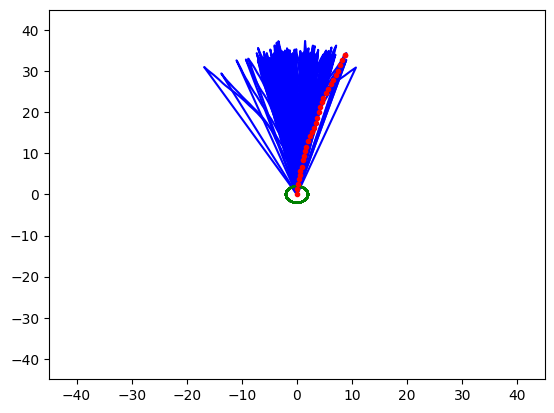

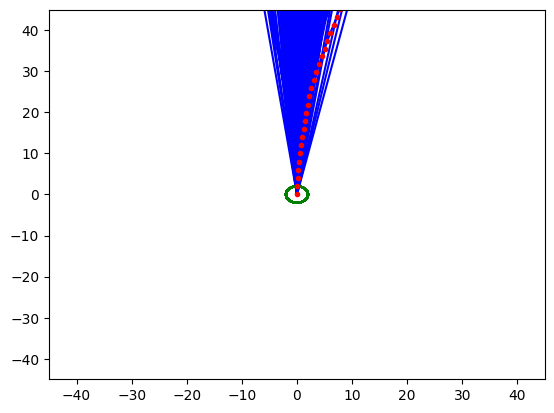

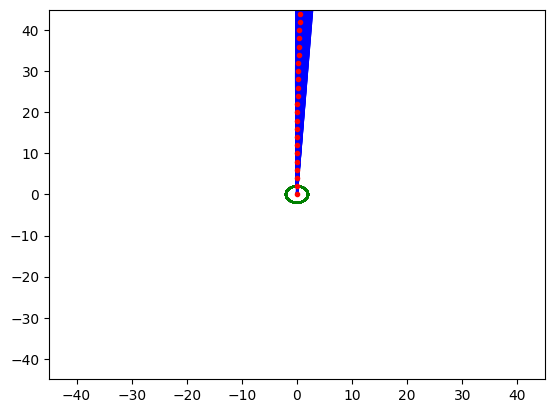

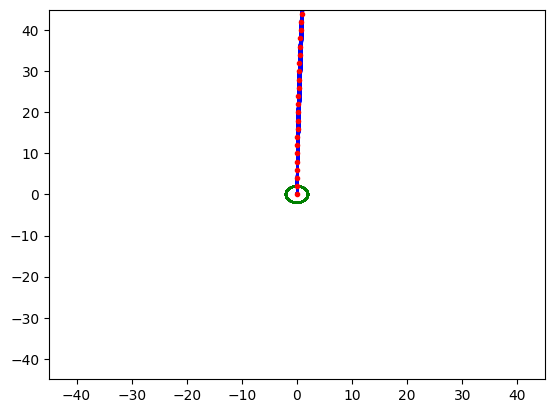

<Figure size 640x480 with 0 Axes>

In [219]:
v_var = 2 #torch.tensor([0.5])
w_var = 2 #torch.tensor([0.5])
v_mean = 12
w_mean = 0
for iter in range(4):
    u = torch.randn(N,H,a_dim)
    u[:,:,0] =u[:,:,0]*v_var + v_mean
    u[:,:,1] =u[:,:,1]*w_var + w_mean
    u = clip(u, [8,20], [-0.5,0.5])
    start_state = torch.tensor([0,0,torch.deg2rad(torch.tensor([90]))])
    traj_N = rollout(u,start_state)
    for i in range(N):
        line, = plt.plot(traj_N[i,:,0],traj_N[i,:,1],color='blue')
        draw_circle(0, 0, radius=2)
    # plt.xlim([-45,45])
    # plt.ylim([-45,45])
    # plt.draw()
    # plt.pause(1/60)
    # plt.clf() 
    smoothness_cost_v_N = torch.zeros(N)
    smoothness_cost_w_N = torch.zeros(N)
    for i in range(N):
        for j in range(1,H):
            v1 = u[i,j-1,0]
            v2 = u[i,j,0]
            w1 = u[i,j-1,1]
            w2 = u[i,j,1]
            smoothness_cost_v_N[i] += torch.abs((v2-v1))
            smoothness_cost_w_N[i] += torch.abs((w2-w1))
    total_cost_N = smoothness_cost_v_N + smoothness_cost_w_N
    top_values, top_idx = torch.topk(total_cost_N, int(0.05*N), largest=False, sorted=True)
    top_trajs = torch.index_select(traj_N, 0, top_idx)
    top_controls = torch.index_select(u, 0, top_idx)
    plt.plot(top_trajs[0,:,0],top_trajs[0,:,1],'.r')
    plt.xlim([-45,45])
    plt.ylim([-45,45])
    plt.draw()
    plt.pause(1/60)
    plt.clf() 
    v_mean = v_mean + torch.mean(top_controls[:,:,0])
    v_var = torch.var(top_controls[:,:,0])
    w_mean = torch.mean(top_controls[:,:,1])
    w_var = torch.var(top_controls[:,:,1])

# With obstacle

In [220]:
obs_pos = [0,30]

In [221]:
v_var = 2 #torch.tensor([0.5])
w_var = 2 #torch.tensor([0.5])
v_mean = 12
w_mean = 0

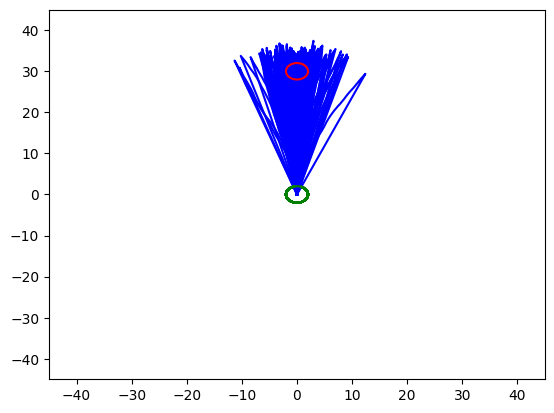

In [222]:
u = torch.randn(N,H,a_dim)
u[:,:,0] =u[:,:,0]*v_var + v_mean
u[:,:,1] =u[:,:,1]*w_var + w_mean
u = clip(u, [8,20], [-0.5,0.5])
start_state = torch.tensor([0,0,torch.deg2rad(torch.tensor([90]))])
traj_N = rollout(u,start_state)
for i in range(N):
    line, = plt.plot(traj_N[i,:,0],traj_N[i,:,1],color='blue')
    draw_circle(0, 0, radius=2)
draw_circle(obs_pos[0],obs_pos[1],2,'r')
plt.xlim([-45,45])
plt.ylim([-45,45])
plt.draw()

## Collision cost

In [223]:
collision_cost_N = torch.zeros(N)
for i in range(N):
    for j in range(H+1):
        if(torch.linalg.norm(traj_N[i,j,:2]-torch.tensor(obs_pos)) <=2):
            collision_cost_N += 1000           
        

## Select elite trajectories

In [224]:
total_cost_N = collision_cost_N
top_values, top_idx = torch.topk(total_cost_N, int(0.05*N), largest=False, sorted=True)
top_trajs = torch.index_select(traj_N, 0, top_idx)
top_controls = torch.index_select(u, 0, top_idx)

## Update the means and the variance

In [225]:
v_mean = torch.mean(top_controls[:,:,0])
v_var = torch.var(top_controls[:,:,0])
w_mean = torch.mean(top_controls[:,:,1])
w_var = torch.var(top_controls[:,:,1])

In [226]:
print(v_mean)
print(w_mean)
print(v_var)
print(w_var)

tensor(12.1848)
tensor(-0.0229)
tensor(4.4571)
tensor(0.2104)


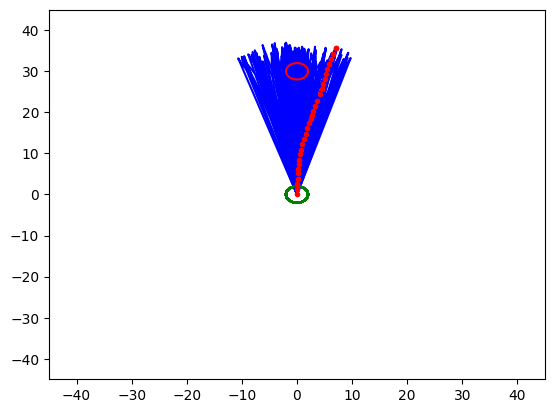

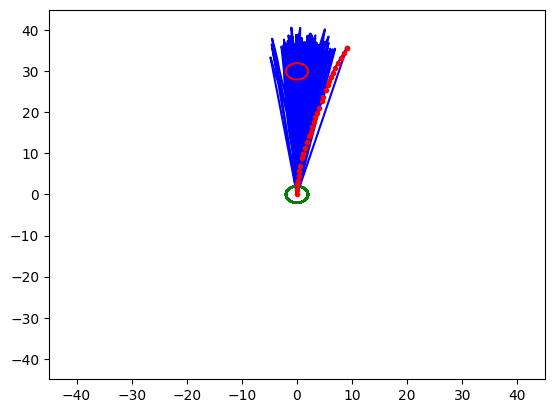

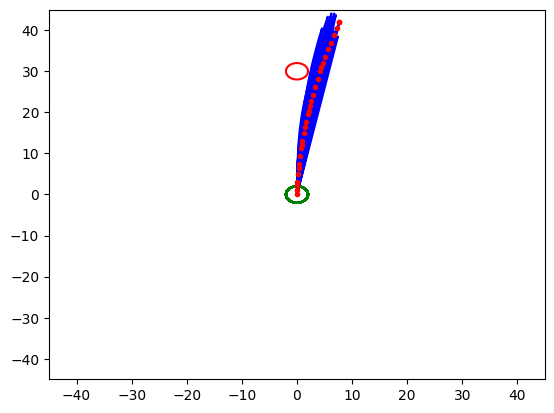

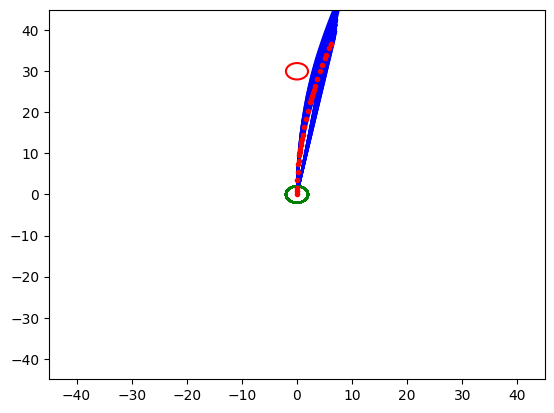

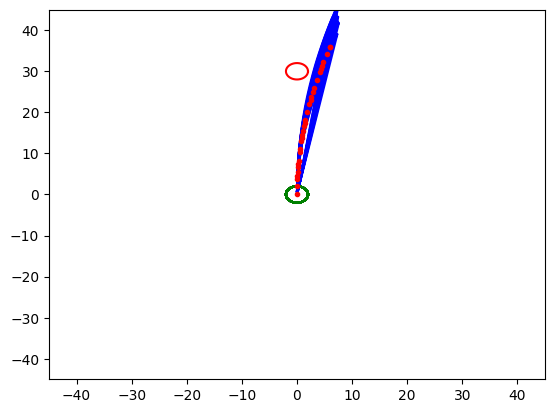

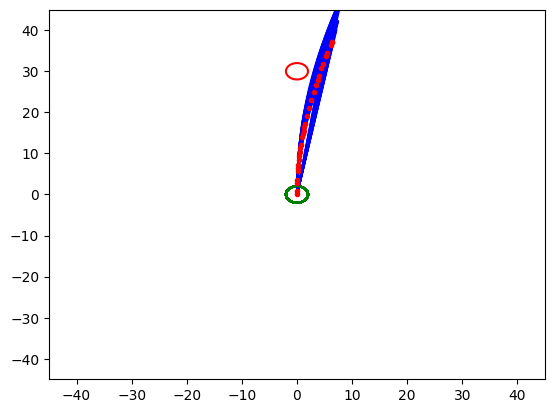

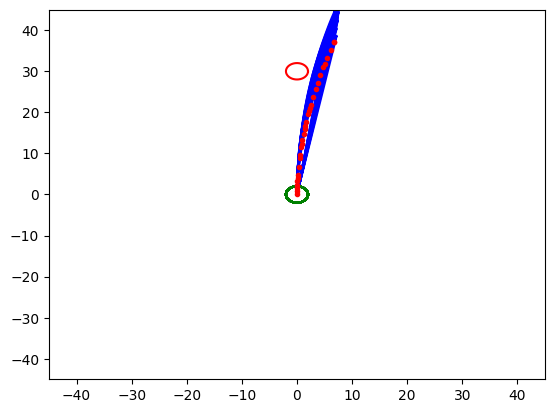

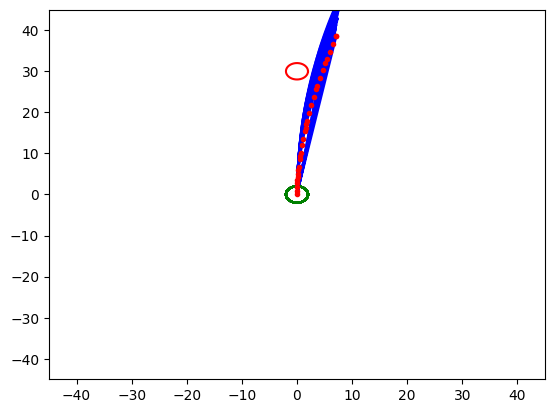

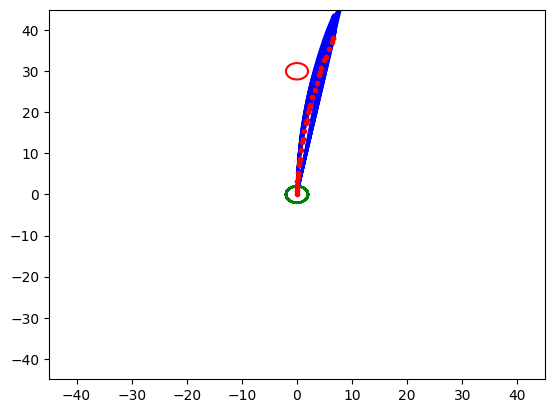

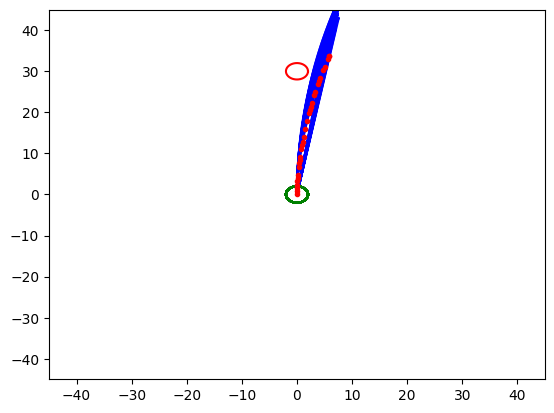

<Figure size 640x480 with 0 Axes>

In [227]:
v_var = 2 #torch.tensor([0.5])
w_var = 2 #torch.tensor([0.5])
v_mean = 12
w_mean = 0
for iter in range(10):
    u = torch.randn(N,H,a_dim)
    u[:,:,0] =u[:,:,0]*v_var + v_mean
    u[:,:,1] =u[:,:,1]*w_var + w_mean
    u = clip(u, [8,20], [-0.5,0.5])
    start_state = torch.tensor([0,0,torch.deg2rad(torch.tensor([90]))])
    traj_N = rollout(u, start_state)
    for i in range(N):
        line, = plt.plot(traj_N[i,:,0],traj_N[i,:,1],color='blue')
        draw_circle(0, 0, radius=2)
    draw_circle(obs_pos[0],obs_pos[1], 2, 'r')

    collision_cost_N = torch.zeros(N)
    for i in range(N):
        for j in range(H):
            if(torch.linalg.norm(traj_N[i,j,:2]-torch.tensor(obs_pos)) <= 4.1):
                collision_cost_N[i] += 1000
    total_cost_N = collision_cost_N
    top_values, top_idx = torch.topk(total_cost_N, int(0.05*N), largest=False, sorted=True)
    top_trajs = torch.index_select(traj_N, 0, top_idx)
    top_controls = torch.index_select(u, 0, top_idx)
    plt.plot(top_trajs[0,:,0],top_trajs[0,:,1],'.r')
    plt.xlim([-45,45])
    plt.ylim([-45,45])
    plt.draw()
    plt.pause(1/60)
    plt.clf() 
    v_mean = torch.mean(top_controls[:,:,0])
    v_var = torch.var(top_controls[:,:,0])
    w_mean = torch.mean(top_controls[:,:,1])
    w_var = torch.var(top_controls[:,:,1])